In [2]:
pip install chart-studio


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta

rcParams['figure.figsize'] = 11, 9


In [4]:
pip install yahoofinancials

Note: you may need to restart the kernel to use updated packages.


In [5]:
from yahoofinancials import YahooFinancials
from joblib import Memory

TMPDIR = '/tmp'
memory = Memory(TMPDIR, verbose=0)

In [6]:
def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]    

In [7]:
DATASET_SOURCE = 'LIVE' 
start_date = '2003-11-19'
end_date = datetime.now().strftime('%Y-%m-%d')

In [9]:
if DATASET_SOURCE == 'LIVE':
    ntdoy = fetch_ticker_data('NTDOY', start_date, end_date)
    ntdoy.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
    ntdoy['DateTime'] = ntdoy['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
    ntdoy = ntdoy.fillna(method="ffill", axis=0)
    ntdoy = ntdoy.fillna(method="bfill", axis=0)
    ntdoy = ntdoy.set_index('DateTime')    
else:
    ntdoy = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/orcl.us.txt', index_col='Date', parse_dates=['Date'])
    ntdoy = ntdoy['2003':]

ntdoy['Name'] = 'NTDOY'
ntdoy.head()

,Open,High,Low,Close,Volume,Name
DateTime,,,,,,
2003-11-20 01:00:00,2.14,2.16,2.08,2.073791,156500,NTDOY
2003-11-21 01:00:00,2.10,2.13,2.10,2.035028,333500,NTDOY
2003-11-22 01:00:00,2.11,2.11,2.05,2.044719,208000,NTDOY
2003-11-25 01:00:00,2.13,2.13,2.06,2.064100,288500,NTDOY
2003-11-26 01:00:00,2.16,2.16,2.11,2.093172,193500,NTDOY


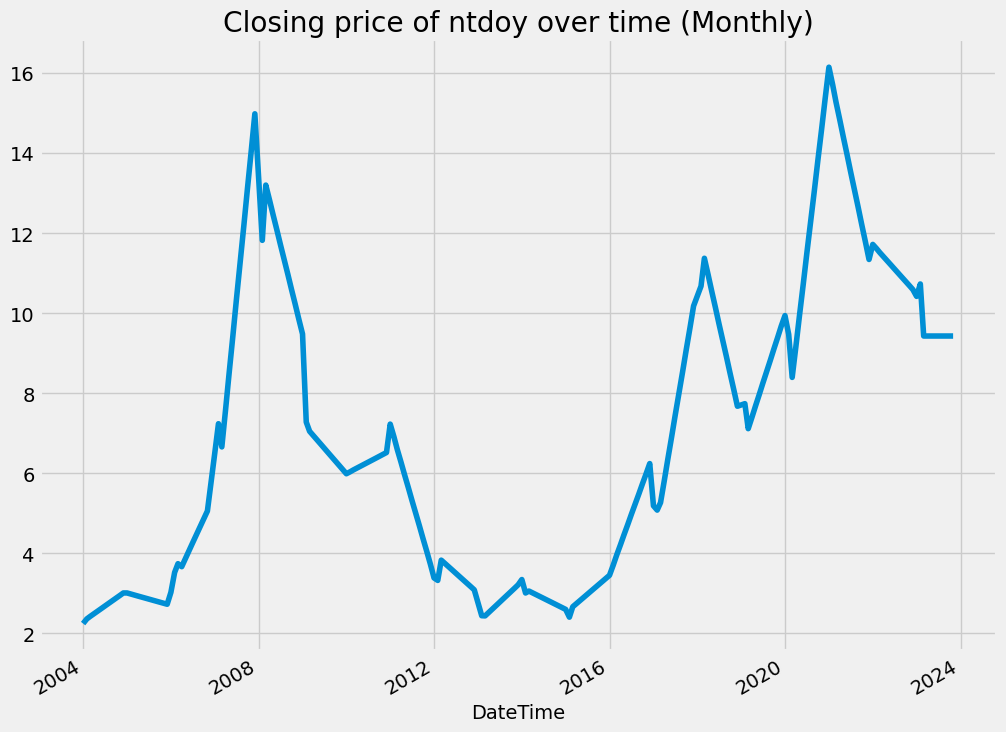

In [11]:
# Visualize data
ntdoy["Close"].asfreq('M').interpolate().plot() 
plt.title('Closing price of ntdoy over time (Monthly)')
plt.show()

What are timestamps and periods and how are they useful?
Timestamps are used to represent a point in time. Periods represent an interval in time. Periods can used to check if a specific event in the given period. They can also be converted to each other's form.

These are the components of a time series


Trend - Consistent upwards or downwards slope of a time series
Seasonality - Clear periodic pattern of a time series(like sine funtion)
Noise - Outliers or missing values

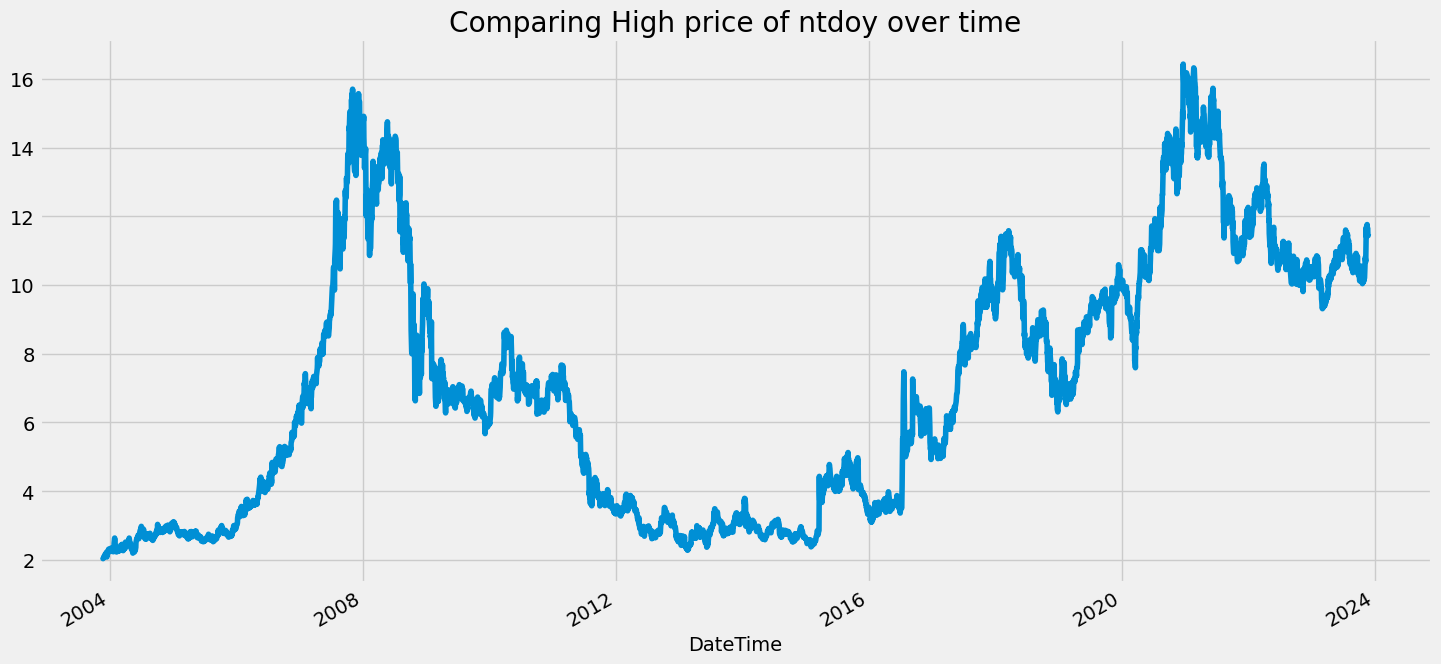

In [42]:
# take close for this
ntdoy["Close"].plot(figsize=(16,8))
_ = plt.title('Comparing High price of ntdoy over time')

Decomposing closing price of Ntdoy over time


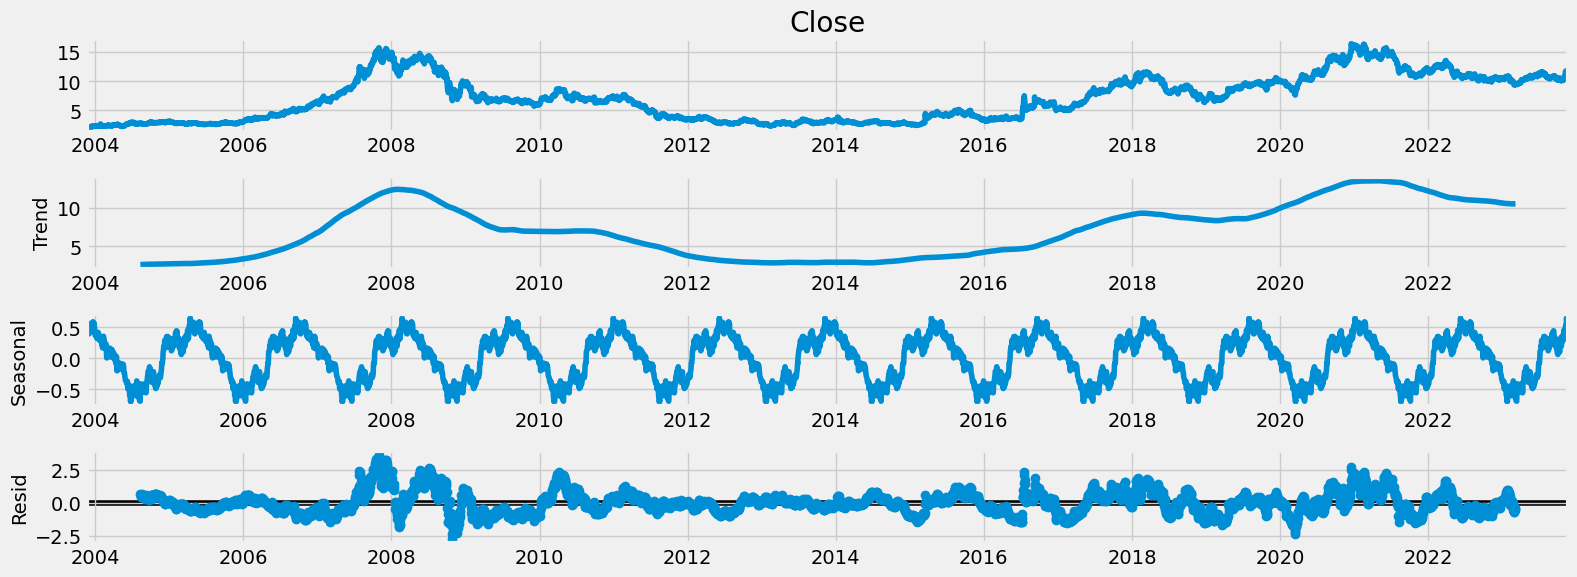

In [51]:
print('Decomposing closing price of Ntdoy over time')
decomposed_ntdoy_close = sm.tsa.seasonal_decompose(ntdoy["Close"], period=360)  # Frequency is annual
figure = decomposed_ntdoy_close.plot()
plt.show()


3.4 Stationarity

A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.

Strong stationarity: is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.
Weak stationarity: is a process where mean, variance, autocorrelation are constant throughout the time
Stationarity is important as non-stationary series that depend on time have too many parameters to account for when modelling the time series. diff() method can easily convert a non-stationary series to a stationary series.

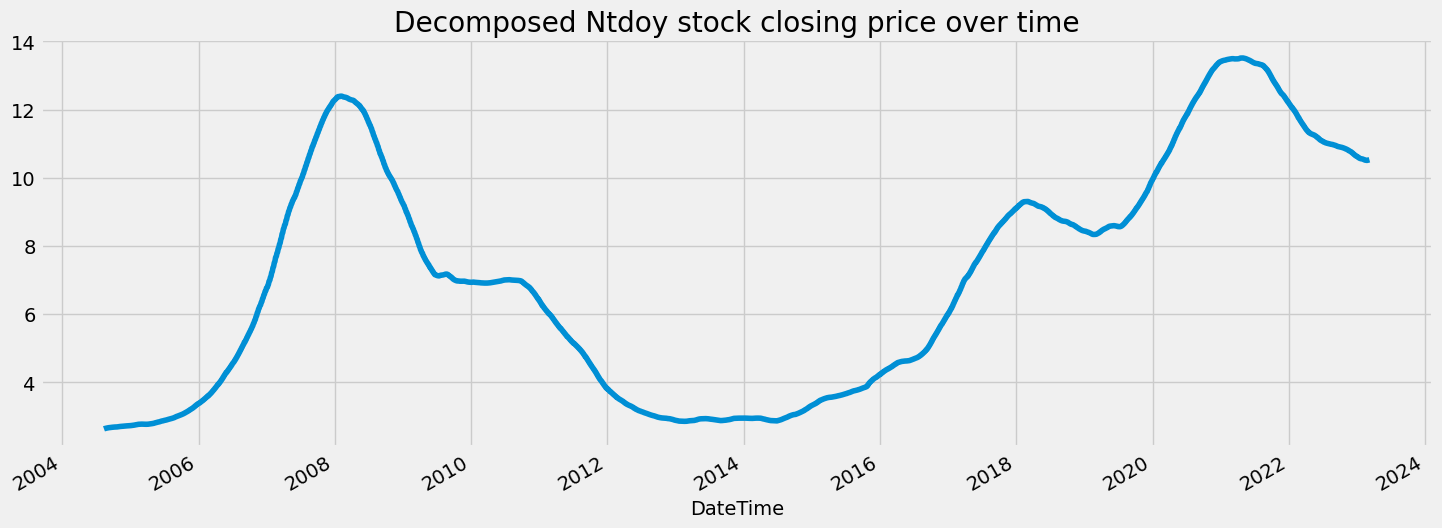

In [52]:
# The original non-stationary plot
decomposed_ntdoy_close.trend.plot()
_ = plt.title('Decomposed Ntdoy stock closing price over time')

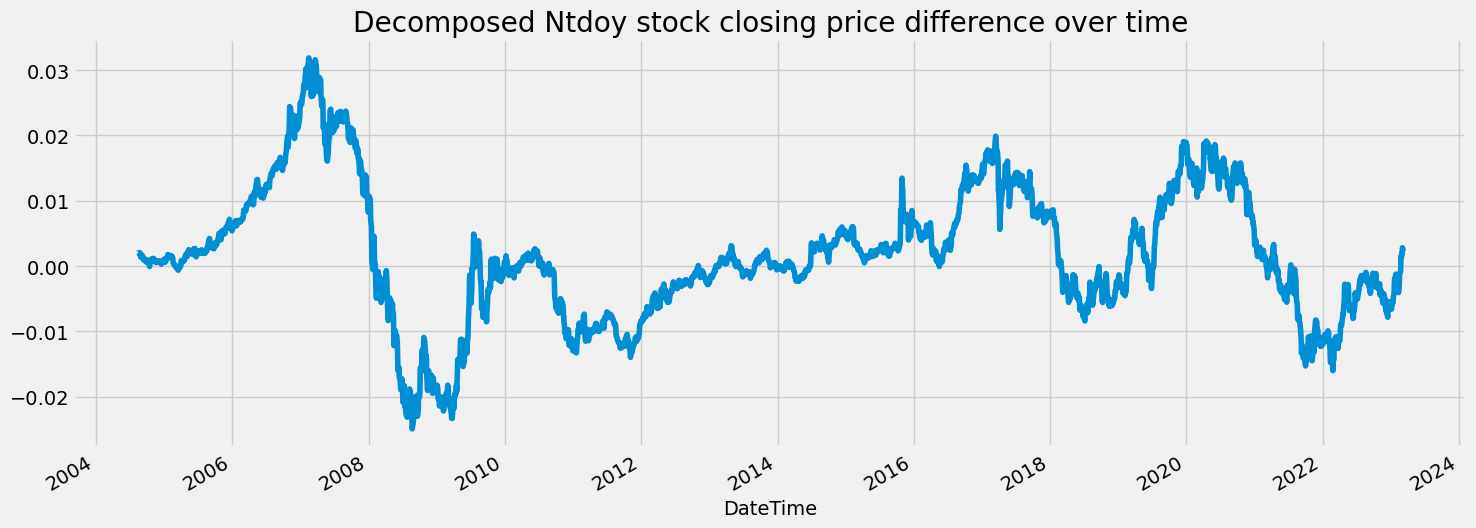

In [53]:
# The original non-stationary plot
decomposed_ntdoy_close.trend.diff().plot()
_ = plt.title('Decomposed Ntdoy stock closing price difference over time')

In [56]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
# Apply ADF test on the original data
check_stationarity(ntdoy['Close'])

ADF Statistic: -1.611381
p-value: 0.477251
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


ADF Statistic: The more negative this statistic is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence. Your value of -1.611381 is not negative enough to fall below the critical value thresholds.

p-value: To reject the null hypothesis that there is a unit root (non-stationarity), we want a low p-value. Typically, a p-value below 0.05 indicates stationarity. Your p-value of 0.477251 is above 0.05, which means we fail to reject the null hypothesis of non-stationarity at a 95% confidence level.

Critical Values: These are the thresholds that your ADF statistic needs to be below to reject the null hypothesis at the 1%, 5%, and 10% levels. Since your ADF statistic is not lower than any of these, it indicates non-stationarity.

An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity. ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5035
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 775.096
Date:                Wed, 22 Nov 2023   AIC                          -1544.192
Time:                        21:50:18   BIC                          -1524.620
Sample:                             0   HQIC                         -1537.335
                               - 5035                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6582      0.008    -86.774      0.000      -0.673      -0.643
ar.L2         -0.3294      0.008    -41.237      0.000      -0.345      -0.314
sigma2         0.0430      0.000    102.269      0.0

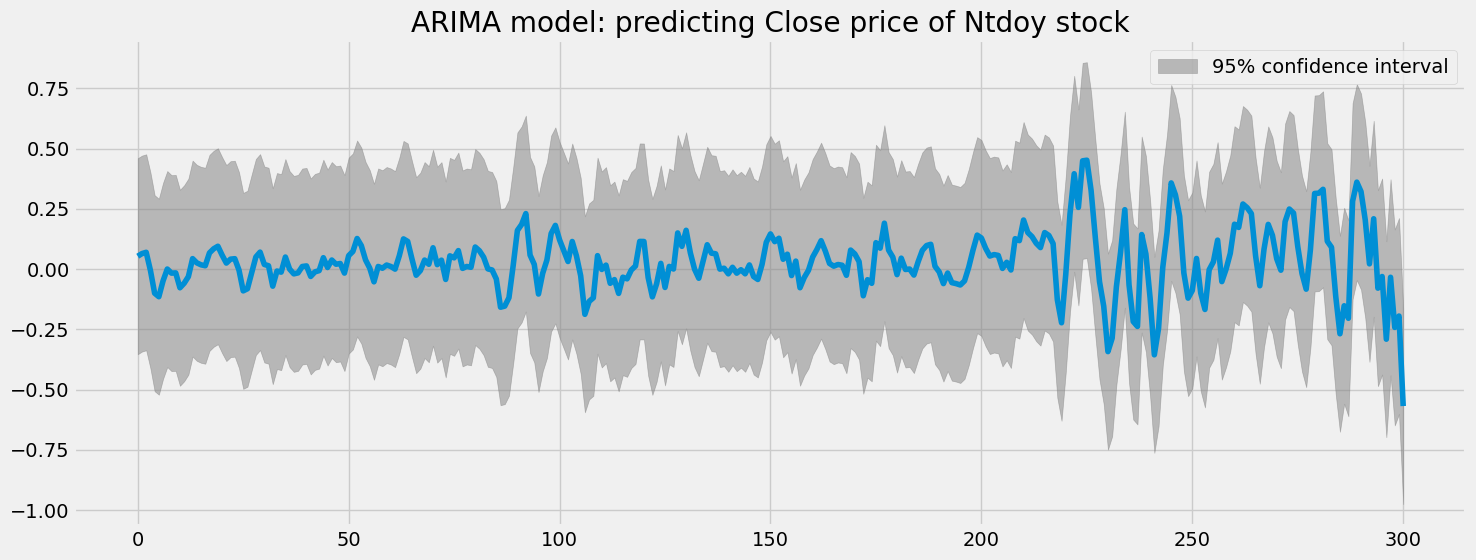

In [25]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from matplotlib import rcParams

# Assuming you have already imported your data into the 'ntdoy' DataFrame

# Set the figure size
rcParams['figure.figsize'] = 16, 6

# Fit the ARIMA model
model = ARIMA(ntdoy["Close"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()

# Print model summary
print(result.summary())

# Plot the predicted values
fig, ax = plt.subplots()
plot_predict(result, start=700, end=1000, ax=ax)
ax.set_title('ARIMA model: predicting Close price of Ntdoy stock')
plt.show()


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
true_values = ntdoy["Close"].diff().iloc[700:1001].values
predicted_values = result.predict(start=700, end=1000)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_values)
print("Mean Absolute Error (MAE): {}".format(mae))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_values)
print("Mean Squared Error (MSE): {}".format(mse))

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(true_values, predicted_values, squared=False)
print("Root Mean Squared Error (RMSE): {}".format(rmse))

# Calculate r-squared (R2) score
r2 = r2_score(true_values, predicted_values)
print("r-squared (R2) score: {}".format(r2))


Mean Absolute Error (MAE): 0.11171627655430266
Mean Squared Error (MSE): 0.027438978921292455
Root Mean Squared Error (RMSE): 0.1656471518659239
r-squared (R2) score: 0.3890402485290402
